In [1]:
#importing libraries
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
import numpy as np
import pandas as pd

dataset = pd.read_csv(r'C:\Users\Anupam Mishra\Desktop\New folder\Basic-Sentiment-Model\sentiment.csv')

sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [3]:
vocab_size = 500
embedding_dim = 16
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "lstmgcv"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            8000      
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 8,109
Trainable params: 8,109
Non-trainable params: 0
_________________________________________________________________


In [5]:
num_epochs = 30
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/30
50/50 [==============================] - 1s 5ms/step - loss: 0.6917 - accuracy: 0.5210 - val_loss: 0.6973 - val_accuracy: 0.4110
Epoch 2/30
50/50 [==============================] - 0s 2ms/step - loss: 0.6892 - accuracy: 0.5223 - val_loss: 0.6973 - val_accuracy: 0.4286
Epoch 3/30
50/50 [==============================] - 0s 1ms/step - loss: 0.6853 - accuracy: 0.5581 - val_loss: 0.6942 - val_accuracy: 0.4486
Epoch 4/30
50/50 [==============================] - 0s 1ms/step - loss: 0.6791 - accuracy: 0.5631 - val_loss: 0.6884 - val_accuracy: 0.4887
Epoch 5/30
50/50 [==============================] - 0s 1ms/step - loss: 0.6700 - accuracy: 0.6215 - val_loss: 0.6783 - val_accuracy: 0.5614
Epoch 6/30
50/50 [==============================] - 0s 2ms/step - loss: 0.6568 - accuracy: 0.6598 - val_loss: 0.6684 - val_accuracy: 0.5840
Epoch 7/30
50/50 [==============================] - 0s 2ms/step - loss: 0.6395 - accuracy: 0.7163 - val_loss: 0.6485 - val_accuracy: 0.6892
Epoch 8/30
50/50 [==

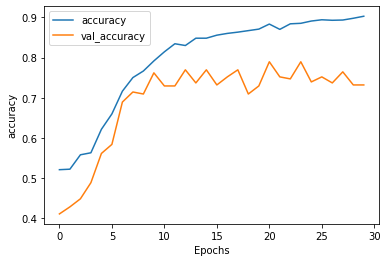

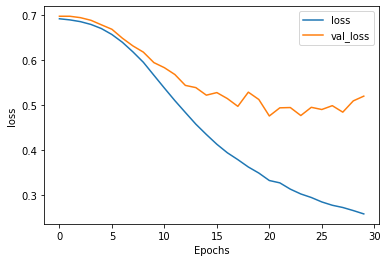

In [6]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [7]:
# First get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(500, 16)


In [8]:
import io

# Create the reverse word index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Write out the embedding vectors and metadata
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [14]:
# Use the model to predict a review   
random_reviews = ['I will call u ', 'I hate spaghetti', 
                'Everything was cold',
                'Everything was hot exactly as I wanted', 
                'Everything was green', 
                'the host seated us immediately',
                'they gave us free chocolate cake', 
                'not sure about the wilted flowers on the table',
                'only works when I stand on tippy toes', 
                'does not work when I stand on my head',
               'This product is very good to use']

print(random_reviews) 

# Create the sequences
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(random_reviews)
fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length)           

print('\n\n')              

classes = model.predict(fakes_padded)

# The closer the class is to 1, the more positive the review is deemed to be
for x in range(len(random_reviews)):
  print(random_reviews[x])
  print(classes[x])
  print('\n')



['I will call u ', 'I hate spaghetti', 'Everything was cold', 'Everything was hot exactly as I wanted', 'Everything was green', 'the host seated us immediately', 'they gave us free chocolate cake', 'not sure about the wilted flowers on the table', 'only works when I stand on tippy toes', 'does not work when I stand on my head', 'This product is very good to use']



I will call u 
[0.4073742]


I hate spaghetti
[0.20097756]


Everything was cold
[0.66578585]


Everything was hot exactly as I wanted
[0.49095663]


Everything was green
[0.66578585]


the host seated us immediately
[0.6572999]


they gave us free chocolate cake
[0.88729113]


not sure about the wilted flowers on the table
[0.12629816]


only works when I stand on tippy toes
[0.8857549]


does not work when I stand on my head
[0.03081781]


This product is very good to use
[0.9107759]


